## Import

In [157]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import requests
import urllib.request
import ssl
import re
from numpy.linalg import norm
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
OHCO = ['title_id', 'act_id', 'scene_id', 'speaker_id', 'line_id']

## Get Documents

In [3]:
doc_link_titles = [
    'allswell',
    'asyoulikeit',
    'comedy_errors',
    'cymbeline',
    'lll',
    'measure',
    'merry_wives',
    'merchant',
    'midsummer',
    'much_ado',
    'pericles',
    'taming_shrew',
    'tempest',
    'troilus_cressida',
    'twelfth_night',
    'two_gentlemen',
    'winters_tale',
    '1henryiv',
    '2henryiv',
    'henryv',
    '1henryvi',
    '2henryvi',
    '3henryvi',
    'henryviii',
    'john',
    'richardii',
    'richardiii',
    'cleopatra',
    'coriolanus',
    'hamlet',
    'julius_caesar',
    'lear',
    'macbeth',
    'othello',
    'romeo_juliet',
    'timon',
    'titus'
]

In [4]:
link_base = 'https://shakespeare.mit.edu/'
link_end = '/full.html'

In [5]:
doc_links = [link_base + title + link_end for title in doc_link_titles]

In [6]:
# Create an SSL context
context = ssl.create_default_context()
context.options |= ssl.OP_NO_TLSv1 | ssl.OP_NO_TLSv1_1  # Disable older versions of TLS
context.set_ciphers('DEFAULT@SECLEVEL=1')  # Set the security level

/var/folders/bh/lhwf5km11ql4b9yln2kz8ddh0000gn/T/ipykernel_11722/3760990005.py:3: DeprecationWarning: ssl.OP_NO_SSL*/ssl.OP_NO_TLS* options are deprecated
  context.options |= ssl.OP_NO_TLSv1 | ssl.OP_NO_TLSv1_1  # Disable older versions of TLS


In [7]:
doc_strings = []
for link in doc_links:
    html_file = urllib.request.urlopen(link, context=context)
    html_bytes = html_file.read()
    html_str = html_bytes.decode('utf8')
    html_file.close()
    doc_strings.append(html_str)

## Make CORPUS

In [8]:
def corpus_maker(doc_strings, OHCO, pos_bag='line_id'):
    title_ids = []
    act_ids = []
    scene_ids = []
    speaker_ids = []
    line_ids = []
    lines = []
    for doc in doc_strings: #for each document,
        title = BeautifulSoup(doc).find('title').string[:-15]
        for i in BeautifulSoup(doc).find_all('a', href=False): #for each line (in each doc),

            if re.match(r'^speech', i.attrs['name']):
                speaker = i.text #extract speaker

            else:
                title_ids.append(title)
                act_scene_line = i.attrs['name'].split('.') #extract act.scene.line
                act_ids.append(act_scene_line[0]) #append act_id
                scene_ids.append(act_scene_line[1]) #apppend scene_id
                line_ids.append(act_scene_line[2]) #append line_id
                lines.append(i.text) #append line
                speaker_ids.append(title+'_'+speaker) #append speaker
    
    df = pd.DataFrame({
        'title_id': title_ids,
        'act_id': act_ids,
        'scene_id': scene_ids,
        'speaker_id': speaker_ids,
        'line_id': line_ids,
        'line': lines}
    ).set_index(OHCO)
    
    # Get tokens and terms
    df_0 = df['line'].str.split(expand=True).stack().to_frame('token_str')
    df_0['term_str'] = df_0['token_str'].str.replace(r'\W+', '', regex=True).str.lower()
    df_0.index.names = df_0.index.names[:-1] + ['token_id']
    
    # Tag PoS
    bag_idx = OHCO.index(pos_bag) + 1
    df_pos = df_0.groupby(OHCO[:bag_idx])['token_str'].agg(lambda x: ' '.join(map(str, x))).reset_index().set_index(OHCO[:bag_idx])
    df_pos.columns = ['sent_str']
    df_pos['sent_str'] = df_pos['sent_str'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
    df_pos = df_pos['sent_str'].apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)),
                                                                      dtype='object')).stack().to_frame('pos_tuple')
    
    # Final token table with POS info
    df_pos['pos'] = df_pos['pos_tuple'].apply(lambda x: x[1])
    df_pos['token_str'] = df_pos['pos_tuple'].apply(lambda x: x[0])
    df_pos['term_str'] = df_pos['token_str'].str.lower()
    df_pos['pos_group'] = df_pos['pos'].str[:2]
    df_pos.index.names = df_pos.index.names[:-1] + ['token_id']
    df_pos = df_pos.loc[:, ['token_str', 'term_str', 'pos', 'pos_group']]
    
    return df_pos



In [9]:
CORPUS = corpus_maker(doc_strings, OHCO)

In [10]:
CORPUS.head(5)

token_str  \
title_id                  act_id scene_id speaker_id                        line_id token_id             
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0              And   
                                                                                    1                I   
                                                                                    2               in   
                                                                                    3            going   
                                                                                    4            madam   

                                                                                             term_str  \
title_id                  act_id scene_id speaker_id                        line_id token_id            
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0             and   
                                                                                    1               i   
                                                                                    2              in   
                                                                                    3           going   
                                                                                    4           madam   

                                                                                              pos  \
title_id                  act_id scene_id speaker_id                        line_id token_id        
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0          CC   
                                                                                    1         PRP   
                                                                                    2          IN   
                                                                                    3         VBG   
                                                                                    4          JJ   

                                                                                             pos_group  
title_id                  act_id scene_id speaker_id                        line_id token_id            
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0               CC  
                                                                                    1               PR  
                                                                                    2               IN  
                                                                                    3               VB  
                                                                                    4               JJ

## Make LIB

In [11]:
titles = []
for doc in doc_strings: #for each document,
    titles.append(BeautifulSoup(doc).find('title').string[:-15])
        
play_info = {
    'Taming of the Shrew': [1585, 'Comedy', 34],
    'Henry VI, part 2': [1591, 'History', 60],
    'Henry VI, part 3': [1592, 'History', 43],
    'Two Gentlemen of Verona': [1594, 'Comedy', 17],
    'Titus Andronicus': [1592, 'Tragedy', 24],
    'Henry VI, part 1': [1592, 'History', 54],
    'Richard III': [1593, 'History', 53],
    'Comedy of Errors': [1594, 'Comedy', 19],
    "Love's Labour's Lost": [1595, 'Comedy', 19],
    "Midsummer Night's Dream": [1595, 'Comedy', 22],
    'Romeo and Juliet': [1595, 'Tragedy', 32],
    'Richard II': [1595, 'History', 34],
    'King John': [1596, 'History', 27],
    'Merchant of Venice': [1596, 'Comedy', 22],
    'Henry IV, part 1': [1596, 'History', 34],
    'Henry IV, part 2': [1597, 'History', 52],
    'Much Ado About Nothing': [1598, 'Comedy', 23],
    'Henry V': [1599, 'History', 44],
    'As You Like It': [1599, 'Comedy', 26],
    'Julius Caesar': [1599, 'Tragedy', 47],
    'Hamlet': [1600, 'Tragedy', 30],
    'Merry Wives of Windsor': [1599, 'Comedy', 23],
    'Twelfth Night': [1601, 'Comedy', 18],
    'Troiles and Cressida': [1601, 'Comedy', 27],
    'Othello': [1604, 'Tragedy', 25],
    'Measure for Measure': [1604, 'Comedy', 23],
    "All's Well That Ends Well": [1604, 'Comedy', 22],
    'Timon of Athens': [1605, 'Tragedy', 48],
    'King Lear': [1605, 'Tragedy', 25],
    'Macbeth': [1606, 'Tragedy', 38],
    'Antony and Cleopatra': [1606, 'Tragedy', 53],
    'Coriolanus': [1608, 'Tragedy', 49],
    'Pericles': [1608, 'Comedy', 43],
    'Cymbeline': [1610, 'Comedy', 37],
    "Winter's Tale": [1611, 'Comedy', 33],
    'The Tempest': [1611, 'Comedy', 19],
    'Henry VIII': [1613, 'History', 43]
} 
written_years = {key: values[0] for key, values in play_info.items()}
genres = {key: values[1] for key, values in play_info.items()}
n_characters = {key: values[2] for key, values in play_info.items()}
# these years are the middle of the range for a given play,
# rounded down (i.e. 1593/1594 -> 1593)
# https://www.rsc.org.uk/shakespeares-plays/histories-timeline/timeline (source)
# https://www.statista.com/statistics/1061409/character-count-shakespeare-plays/

LIB = pd.DataFrame({
    'title_id': titles,
    'link': doc_links
})
# get additional features of the texts
LIB['year_written'] = LIB['title_id'].map(written_years)
LIB['genre'] = LIB['title_id'].map(genres)
LIB['n_characters'] = LIB['title_id'].map(n_characters)
LIB['monarch'] = LIB['year_written'].apply(lambda x: 'Elizabeth I' if x < 1603 else 'James I')

LIB = LIB.merge(CORPUS.reset_index().groupby(['title_id'])['act_id'].nunique(),
                on='title_id') # get n_acts
LIB = LIB.merge(CORPUS.reset_index().groupby(['title_id', 'act_id'])['scene_id'].nunique().groupby(['title_id']).sum(),
                on='title_id') #get n_scenes
LIB = LIB.merge(CORPUS.reset_index().groupby(['title_id', 'act_id', 'scene_id'])['line_id'].nunique().groupby(['title_id']).sum(),
                on='title_id') #get n_lines
LIB = LIB.merge(CORPUS.reset_index().groupby(['title_id', 'act_id', 'scene_id', 'line_id'])['token_id'].nunique().groupby(['title_id']).sum(),
                on='title_id') #get n_tokens
LIB = LIB.merge(CORPUS['term_str'].str.len().groupby('title_id').sum(),
                on='title_id') #get n_chars

LIB.columns = list(LIB.columns[:6]) + ['n_acts', 'n_scenes', 'n_lines', 'n_tokens', 'n_chars']
LIB = LIB.set_index('title_id')
LIB.sample(5)

,link,year_written,genre,n_characters,monarch,n_acts,n_scenes,n_lines,n_tokens,n_chars
title_id,,,,,,,,,,
Pericles,https://shakespeare.mit.edu/pericles/full.html,1608,Comedy,43,James I,5,23,2466,17804,72743
Cymbeline,https://shakespeare.mit.edu/cymbeline/full.html,1610,Comedy,37,James I,5,26,3748,26710,109200
Merry Wives of Windsor,https://shakespeare.mit.edu/merry_wives/full.html,1599,Comedy,23,Elizabeth I,5,23,2610,21070,83860
As You Like It,https://shakespeare.mit.edu/asyoulikeit/full.html,1599,Comedy,26,Elizabeth I,5,22,2677,21303,84526
Troiles and Cressida,https://shakespeare.mit.edu/troilus_cressida/f...,1601,Comedy,27,Elizabeth I,5,25,3487,25473,105283


In [12]:
CORPUS.head()

token_str  \
title_id                  act_id scene_id speaker_id                        line_id token_id             
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0              And   
                                                                                    1                I   
                                                                                    2               in   
                                                                                    3            going   
                                                                                    4            madam   

                                                                                             term_str  \
title_id                  act_id scene_id speaker_id                        line_id token_id            
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0             and   
                                                                                    1               i   
                                                                                    2              in   
                                                                                    3           going   
                                                                                    4           madam   

                                                                                              pos  \
title_id                  act_id scene_id speaker_id                        line_id token_id        
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0          CC   
                                                                                    1         PRP   
                                                                                    2          IN   
                                                                                    3         VBG   
                                                                                    4          JJ   

                                                                                             pos_group  
title_id                  act_id scene_id speaker_id                        line_id token_id            
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0               CC  
                                                                                    1               PR  
                                                                                    2               IN  
                                                                                    3               VB  
                                                                                    4               JJ

## Make VOCAB

In [13]:
def get_vocab(TOKENS):
    VOCAB = TOKENS.term_str.value_counts().to_frame('n').sort_index()
    VOCAB.index.name = 'term_str'
    VOCAB['n_chars'] = VOCAB.index.str.len()
    VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
    VOCAB['i'] = -np.log2(VOCAB.p)
    VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
    VOCAB['max_group'] = VOCAB['max_pos'].str[:2]
    
    # Calculate DFIDF
    BOW = TOKENS.groupby(OHCO+['term_str'])['term_str'].count().to_frame('n')
    DTCM = BOW['n'].unstack(fill_value=0)
    DF = DTCM.astype('bool').sum()
    IDF = np.log2(DTCM.shape[0]/DF)
    
    # Merge VOCAB w/ DFIDF
    dfidf = DF*IDF
    dfidf.name = 'dfidf'
    VOCAB = VOCAB.merge(dfidf, on='term_str')
    
    # Porter Stemming
    stemmer = PorterStemmer()
    VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer.stem(x.name), 1)
    
    # Stopword Boolean
    stop_words = set(stopwords.words('english'))
    VOCAB['stop'] = VOCAB.apply(lambda x: x.name in stop_words, axis=1)
    
    return VOCAB

In [14]:
VOCAB = get_vocab(CORPUS)

In [15]:
VOCAB.head()

,n,n_chars,p,i,max_pos,max_group,dfidf,porter_stem,stop
term_str,,,,,,,,,
a,13766,1,0.016944,5.883071,DT,DT,38997.523237,a,True
aaron,25,5,0.000031,14.988037,NNP,NN,291.332922,aaron,False
aarons,1,6,0.000001,19.631893,NNP,NN,16.723834,aaron,False
abaissiez,1,9,0.000001,19.631893,NN,NN,16.723834,abaissiez,False
abandon,3,7,0.000004,18.046930,IN,IN,45.416615,abandon,False


## BOW, DTM, TFIDF, TFIDF (reduced & normed)

In [66]:
def computed_from_corpus(CORPUS, bow_bag, TF_type, top_n=1000):
    # Create BOW from CORPUS based on the bag
    bag_idx = OHCO.index(bow_bag) + 1
    BOW = CORPUS.groupby(OHCO[:bag_idx]+['term_str'])['term_str'].count().to_frame('n')
    
    # Create DTM from CORPUS based on bag
    DTM = BOW['n'].unstack(fill_value=0)
    
    # Create TFIDF table from DTM
    #compute TF
    if TF_type == 'sum':
        TF = DTM.T / DTM.T.sum()
    elif TF_type == 'max':
        TF = DTM.T / DTM.T.max()
    elif TF_type == 'log':
        TF = np.log2(1 + DTM.T)
    elif TF_type == 'double_norm':
        TF = DTM.T / DTCM.T.max()
    elif TF_type == 'raw':
        TF = DTM.T
    elif TF_type == 'binary':
        TF = DTM.T.astype('bool').astype('int')
    TF = TF.T
    
    #compute IDF
    DF = DTM.astype('bool').sum()
    N = DTM.shape[0]
    IDF = np.log2(N / DF) #standard IDF method
    
    TFIDF = TF * IDF
    
    #add tfidf to BOW
    tfidf_long = pd.melt(TFIDF.reset_index(), id_vars=OHCO[:bag_idx], value_vars=list(TFIDF.columns), value_name='tfidf')
    BOW['tfidf'] = tfidf_long.query("tfidf > 0").sort_values(OHCO[:bag_idx]+['term_str']).set_index(OHCO[:bag_idx]+['term_str'])['tfidf'].values
    
    # Create Normalized TFIDF, Filtered to top_n words with highest DFIDF values
    top_n = (DF*IDF).sort_values(ascending=False).head(top_n).index
    TFIDF_n = TFIDF.T.loc[top_n].T.groupby(OHCO[:bag_idx]).mean()
    TFIDF_norm = TFIDF_n.apply(lambda x: x / norm(x), 1)
    
    return BOW, DTM, TFIDF, TFIDF_norm

In [67]:
BOW, DTM, TFIDF, TFIDF_norm = computed_from_corpus(CORPUS, 'scene_id', 'sum')

In [68]:
BOW.sample(5)

,,,,n,tfidf
title_id,act_id,scene_id,term_str,,
"Henry VI, part 3",5,4,gainsay,1,0.011324
Cymbeline,5,1,to,11,0.000925
King Lear,2,1,bastard,1,0.004041
Antony and Cleopatra,3,6,nor,2,0.002656
King Lear,1,1,ever,5,0.002585


In [69]:
DTM.sample(5)

term_str                                    a  aaron  aarons  abaissiez  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 4      2          7      0       0          0   
Much Ado About Nothing    1      1         71      0       0          0   
                          3      5         11      0       0          0   
Henry IV, part 1          2      1         21      0       0          0   
Henry VI, part 1          4      7         12      0       0          0   

term_str                                   abandon  abandond  abandoned  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 4      2               0         0          0   
Much Ado About Nothing    1      1               0         0          0   
                          3      5               0         0          0   
Henry IV, part 1          2      1               0         0          0   
Henry VI, part 1          4      7               0         0          0   

term_str                                   abandonwhich  abase  abashd  ...  \
title_id                  act_id scene_id                               ...   
All's Well That Ends Well 4      2                    0      0       0  ...   
Much Ado About Nothing    1      1                    0      0       0  ...   
                          3      5                    0      0       0  ...   
Henry IV, part 1          2      1                    0      0       0  ...   
Henry VI, part 1          4      7                    0      0       0  ...   

term_str                                   zenelophon  zenith  zephyrs  zir  \
title_id                  act_id scene_id                                     
All's Well That Ends Well 4      2                  0       0        0    0   
Much Ado About Nothing    1      1                  0       0        0    0   
                          3      5                  0       0        0    0   
Henry IV, part 1          2      1                  0       0        0    0   
Henry VI, part 1          4      7                  0       0        0    0   

term_str                                   zo  zodiac  zodiacs  zone  zounds  \
title_id                  act_id scene_id                                      
All's Well That Ends Well 4      2          0       0        0     0       0   
Much Ado About Nothing    1      1          0       0        0     0       0   
                          3      5          0       0        0     0       0   
Henry IV, part 1          2      1          0       0        0     0       1   
Henry VI, part 1          4      7          0       0        0     0       0   

term_str                                   zwaggered  
title_id                  act_id scene_id             
All's Well That Ends Well 4      2                 0  
Much Ado About Nothing    1      1                 0  
                          3      5                 0  
Henry IV, part 1          2      1                 0  
Henry VI, part 1          4      7                 0  

[5 rows x 27629 columns]

In [70]:
TFIDF.sample(5)

,,term_str,a,aaron,aarons,abaissiez,abandon,abandond,abandoned,abandonwhich,abase,abashd,...,zenelophon,zenith,zephyrs,zir,zo,zodiac,zodiacs,zone,zounds,zwaggered
title_id,act_id,scene_id,,,,,,,,,,,,,,,,,,,,,
Coriolanus,1,8,0.001411,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
King Lear,3,3,0.001326,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Henry IV, part 2",2,3,0.000632,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
King John,5,5,0.000321,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Twelfth Night,1,4,0.000889,0.0,0.0,0.0,0.0,0.021278,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
TFIDF_norm.sample(5)

term_str                            heaven       put       set    honour  \
title_id         act_id scene_id                                           
Henry VIII       3      2         0.054641  0.033021  0.022014  0.055034   
King Lear        3      1         0.000000  0.000000  0.052808  0.000000   
Romeo and Juliet 1      0         0.000000  0.000000  0.000000  0.000000   
                 4      1         0.000000  0.029206  0.000000  0.029206   
                 1      3         0.000000  0.000000  0.000000  0.055756   

term_str                               off      long     thing      gone  \
title_id         act_id scene_id                                           
Henry VIII       3      2         0.021778  0.043556  0.022172  0.021622   
King Lear        3      1         0.000000  0.000000  0.053188  0.000000   
Romeo and Juliet 1      0         0.000000  0.000000  0.000000  0.000000   
                 4      1         0.057786  0.057786  0.029416  0.028686   
                 1      3         0.000000  0.027579  0.028079  0.000000   

term_str                              hold      else  ...  meaning  hurt  \
title_id         act_id scene_id                      ...                  
Henry VIII       3      2         0.000000  0.032201  ...      0.0   0.0   
King Lear        3      1         0.000000  0.000000  ...      0.0   0.0   
Romeo and Juliet 1      0         0.000000  0.000000  ...      0.0   0.0   
                 4      1         0.086059  0.000000  ...      0.0   0.0   
                 1      3         0.027382  0.000000  ...      0.0   0.0   

term_str                          view    bitter  fail     fears      amen  \
title_id         act_id scene_id                                             
Henry VIII       3      2          0.0  0.000000   0.0  0.028707  0.057414   
King Lear        3      1          0.0  0.000000   0.0  0.000000  0.000000   
Romeo and Juliet 1      0          0.0  0.000000   0.0  0.000000  0.000000   
                 4      1          0.0  0.000000   0.0  0.000000  0.000000   
                 1      3          0.0  0.072709   0.0  0.000000  0.000000   

term_str                          cries  practise      ways  
title_id         act_id scene_id                             
Henry VIII       3      2           0.0       0.0  0.057414  
King Lear        3      1           0.0       0.0  0.000000  
Romeo and Juliet 1      0           0.0       0.0  0.000000  
                 4      1           0.0       0.0  0.076171  
                 1      3           0.0       0.0  0.000000  

[5 rows x 1000 columns]

## PCA

In [22]:
def pca(TFIDF, k, norm_docs):
    if norm_docs:
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    COV = TFIDF.cov()
    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
    
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
    
    #component information table
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'
    
    #loadings table
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'
    
    #document-component matrix
    DCM = TFIDF.dot(COMPS[COV.index].T)
    DCM = DCM.join(LIB, on='title_id')
    
    return LOADINGS, COMPS, DCM

In [23]:
LOADINGS, COMPONENTS, DCM = pca(TFIDF_norm, 10, norm_docs=True) #have to run on a smaller dataset (too intense on full corpus)

In [24]:
LOADINGS.head()

pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
heaven,-0.037500,-0.060839,-0.035925,-0.000222,0.044341,0.008442,0.009392,-0.027970,0.017061,-0.049136
put,-0.032512,0.002576,-0.020933,-0.027287,-0.001703,0.042308,0.016896,-0.012485,0.009752,0.020223
set,0.009964,-0.025369,-0.010308,-0.012917,0.014660,-0.000662,0.018194,0.002448,0.022681,-0.001691
honour,-0.021713,-0.045630,-0.042763,0.004720,-0.043159,0.077443,0.026341,0.018574,0.012303,0.030984
off,-0.005750,-0.022694,-0.020214,-0.035342,0.006179,0.003274,0.005511,-0.006976,0.001706,0.019049


In [25]:
COMPONENTS.head()

,eig_val,heaven,put,set,honour,off,long,thing,gone,hold,...,hurt,view,bitter,fail,fears,amen,cries,practise,ways,exp_var
pc_id,,,,,,,,,,,,,,,,,,,,,
PC0,0.020443,-0.037500,-0.032512,0.009964,-0.021713,-0.005750,-0.017903,-0.045393,-0.028336,-0.020172,...,-0.014081,-0.000914,-0.017025,-0.000331,0.002109,-0.006329,0.003379,-0.024751,-0.023710,2.40
PC1,0.017070,-0.060839,0.002576,-0.025369,-0.045630,-0.022694,-0.027188,-0.002143,0.000615,-0.007813,...,0.001084,-0.009606,-0.020183,0.007519,-0.015392,-0.004106,-0.012165,-0.005115,0.015039,2.00
PC2,0.013514,-0.035925,-0.020933,-0.010308,-0.042763,-0.020214,-0.000392,-0.016071,-0.016766,-0.002561,...,0.003586,-0.014873,-0.006821,-0.007262,-0.016307,-0.000123,-0.013027,-0.011518,0.000476,1.58
PC3,0.011009,-0.000222,-0.027287,-0.012917,0.004720,-0.035342,0.000560,-0.022605,0.017013,-0.016800,...,-0.003428,0.008042,0.015265,0.007674,-0.011293,0.015496,-0.007362,0.008865,-0.000339,1.29
PC4,0.009848,0.044341,-0.001703,0.014660,-0.043159,0.006179,-0.025559,-0.004573,0.005543,0.013137,...,0.034356,0.001611,0.005801,0.007474,0.010941,0.021362,0.024121,-0.000162,-0.016729,1.15


In [26]:
DCM.head()

PC0       PC1       PC2  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1        -0.371005 -0.236662 -0.240065   
                                 2        -0.202281 -0.213224 -0.155320   
                                 3        -0.443313 -0.202035 -0.233907   
                          2      1        -0.290022 -0.313018 -0.254526   
                                 2        -0.267669 -0.072033 -0.036957   

                                                PC3       PC4       PC5  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.006969 -0.026874  0.062214   
                                 2        -0.102491 -0.002747  0.140941   
                                 3         0.180772 -0.082998 -0.035884   
                          2      1        -0.126781  0.002978  0.100710   
                                 2        -0.165565 -0.178550  0.125071   

                                                PC6       PC7       PC8  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.147755  0.016413  0.086478   
                                 2         0.006463 -0.091014 -0.055422   
                                 3         0.312403  0.071932  0.051361   
                          2      1        -0.017534  0.000770  0.038071   
                                 2         0.136152 -0.028108 -0.012979   

                                                PC9  \
title_id                  act_id scene_id             
All's Well That Ends Well 1      1        -0.056144   
                                 2        -0.085064   
                                 3        -0.127672   
                          2      1        -0.007328   
                                 2         0.067963   

                                                                                     link  \
title_id                  act_id scene_id                                                   
All's Well That Ends Well 1      1         https://shakespeare.mit.edu/allswell/full.html   
                                 2         https://shakespeare.mit.edu/allswell/full.html   
                                 3         https://shakespeare.mit.edu/allswell/full.html   
                          2      1         https://shakespeare.mit.edu/allswell/full.html   
                                 2         https://shakespeare.mit.edu/allswell/full.html   

                                           year_written   genre  n_characters  \
title_id                  act_id scene_id                                       
All's Well That Ends Well 1      1                 1604  Comedy            22   
                                 2                 1604  Comedy            22   
                                 3                 1604  Comedy            22   
                          2      1                 1604  Comedy            22   
                                 2                 1604  Comedy            22   

                                           monarch  n_acts  n_scenes  n_lines  \
title_id                  act_id scene_id                                       
All's Well That Ends Well 1      1         James I       5        23     2925   
                                 2         James I       5        23     2925   
                                 3         James I       5        23     2925   
                          2      1         James I       5        23     2925   
                                 2         James I       5        23     2925   

                                           n_tokens  n_chars  
title_id                  act_id scene_id                     
All's Well That Ends Well 1      1            22554    90604  
                                 2            22554    90604  
                                 3          

## LDA

In [27]:
def lda(CORPUS, bow_bag):
    bag_idx = OHCO.index(bow_bag) + 1
    #filter to nouns, verbs, and adjectives only but also remove personal nouns
    DOCS = CORPUS[(CORPUS.pos.str.match(r'^(?!NNP$).*')) & (CORPUS.pos_group.str.match(r'[VB]|[NN]'))]\
        .groupby(OHCO[:bag_idx]).term_str\
        .apply(lambda x: ' '.join(x))\
        .to_frame()\
        .rename(columns={'term_str':'doc_str'})
    
    count_engine = CountVectorizer(max_features=4000, ngram_range=(1, 2), stop_words='english')
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names_out()

    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'

    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
    
    lda_engine = LDA(n_components=20, max_iter=5, learning_offset=50., random_state=0)
    lda_model = lda_engine.fit_transform(count_model)
    
    #make theta table (bag-topic)
    global TNAMES
    TNAMES = [f"T{str(x).zfill(len(str(20)))}" for x in range(20)]

    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES
    
    #make phi table (topic-term)
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name = 'term_str'
    
    # make topic table
    TOPICS = PHI.stack().groupby('topic_id')\
        .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(7).reset_index().term_str))\
        .to_frame('top_terms')
    
    return THETA, PHI, TOPICS

In [28]:
THETA, PHI, TOPICS = lda(CORPUS, 'act_id')

In [29]:
THETA.head()

T00       T01       T02       T03  \
title_id                  act_id                                           
All's Well That Ends Well 1       0.000042  0.000042  0.556316  0.000042   
                          2       0.000032  0.000032  0.896855  0.000032   
                          3       0.000051  0.000051  0.921426  0.000051   
                          4       0.000038  0.000038  0.975447  0.000038   
                          5       0.000051  0.000051  0.967649  0.000051   

                                       T04       T05       T06       T07  \
title_id                  act_id                                           
All's Well That Ends Well 1       0.000042  0.442934  0.000042  0.000042   
                          2       0.000032  0.000032  0.000032  0.000032   
                          3       0.000051  0.000051  0.000051  0.000051   
                          4       0.000038  0.000038  0.000038  0.000038   
                          5       0.000051  0.000051  0.000051  0.000051   

                                       T08       T09       T10       T11  \
title_id                  act_id                                           
All's Well That Ends Well 1       0.000042  0.000042  0.000042  0.000042   
                          2       0.000032  0.000032  0.000032  0.000032   
                          3       0.000051  0.000051  0.000051  0.000051   
                          4       0.000038  0.000038  0.000038  0.000038   
                          5       0.000051  0.000051  0.000051  0.000051   

                                       T12       T13       T14       T15  \
title_id                  act_id                                           
All's Well That Ends Well 1       0.000042  0.000042  0.000042  0.000042   
                          2       0.000032  0.000032  0.102577  0.000032   
                          3       0.000051  0.000051  0.058612  0.019104   
                          4       0.000038  0.000038  0.023873  0.000038   
                          5       0.000051  0.000051  0.000051  0.031429   

                                       T16       T17       T18       T19  
title_id                  act_id                                          
All's Well That Ends Well 1       0.000042  0.000042  0.000042  0.000042  
                          2       0.000032  0.000032  0.000032  0.000032  
                          3       0.000051  0.000051  0.000051  0.000051  
                          4       0.000038  0.000038  0.000038  0.000038  
                          5       0.000051  0.000051  0.000051  0.000051

In [30]:
PHI.head()

term_str,abed,abhor,abide,aboard,absence,absent,abuse,abused,accent,accept,...,yielding,yields,yoke,yond,yonder,youll,youre,youth,zeal,zounds
topic_id,,,,,,,,,,,,,,,,,,,,,
T00,0.050000,0.0500,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
T01,0.050000,0.0500,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
T02,6.079408,10.7869,6.881473,7.529349,27.963088,3.790537,23.361141,26.217139,9.506411,8.299782,...,5.012567,5.696057,7.688861,20.248934,24.015934,53.071118,44.925377,156.052205,10.219947,2.795013
T03,0.050000,0.0500,1.827818,0.050000,1.422282,0.050000,0.050000,1.050000,0.050000,0.050000,...,0.050000,1.050000,1.050000,1.277173,0.202521,0.050000,0.050000,2.218687,0.050000,0.050000
T04,0.050000,0.0500,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000


In [31]:
TOPICS.head()

,top_terms
topic_id,
T00,don love sir lenvoy heart thou master
T01,lords let abed prosperity protection protector...
T02,thou sir let man lord know thee
T03,thou thee love make come did sir
T04,lords let abed prosperity protection protector...


## Sentiment

In [127]:
def combine_sentiment(SENTIMENT, TABLE):
    COMBO = TABLE.reset_index().merge(SENTIMENT.reset_index(), how='inner', on='term_str')
    COMBO_idx = COMBO.set_index('term_str')
    if 'title_id' in COMBO.columns:
        COMBO_idx = COMBO.set_index(OHCO[:1]+['term_str'])
        if 'act_id' in COMBO.columns:
            COMBO_idx = COMBO.set_index(OHCO[:2]+['term_str'])
            if 'scene_id' in COMBO.columns:
                COMBO_idx = COMBO.set_index(OHCO[:3]+['term_str'])
                if 'speaker_id' in COMBO.columns:
                    COMBO_idx = COMBO.set_index(OHCO[:4]+['term_str'])
                    if 'line_id' in COMBO.columns:
                        COMBO_idx = COMBO.set_index(OHCO+['term_str'])
    return COMBO_idx

In [132]:
def sentiment_per_bag(BOW_SENT, bow_bag):
    bag_idx = OHCO.index(bow_bag) + 1
    return BOW_SENT.groupby(OHCO[:bag_idx]).mean()

In [128]:
salex_csv = 'data/lexicons/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [129]:
VOCAB_SENT = combine_sentiment(SALEX, VOCAB)
VOCAB_SENT.sample(5)

,n,n_chars,p,i,max_pos,max_group,dfidf,porter_stem,stop,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,
grime,2,5,0.000002,18.631893,NN,NN,31.447668,grime,False,0,0,1,0,0,1,0,0,0,0,-1
bargain,19,7,0.000023,15.383965,NN,NN,237.042228,bargain,False,0,0,0,0,0,0,1,0,0,1,1
slavery,4,7,0.000005,17.631893,NN,NN,58.895337,slaveri,False,1,0,1,1,0,1,0,1,0,0,-1
ordnance,5,8,0.000006,17.309965,NN,NN,72.009531,ordnanc,False,0,0,0,1,0,1,0,0,0,0,-1
dare,205,4,0.000252,11.952413,VBP,VB,1823.629291,dare,False,0,1,0,0,0,0,0,0,0,1,0


In [130]:
BOW_SENT = combine_sentiment(SALEX, BOW)
BOW_SENT.sample(5)

,,,,n,tfidf,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
title_id,act_id,scene_id,term_str,,,,,,,,,,,,,
"Henry VI, part 2",5,2,proud,1,0.003761,0,1,0,0,1,0,1,0,0,1,1
"Henry IV, part 2",3,2,shot,2,0.003414,1,0,0,1,0,1,0,1,1,0,-1
Henry VIII,4,2,love,2,0.001086,0,0,0,0,1,0,1,0,0,0,1
Merchant of Venice,3,1,title,1,0.003315,0,0,0,0,0,0,1,0,0,1,1
Winter's Tale,5,3,kiss,3,0.006391,0,1,0,0,1,0,1,0,1,0,1


In [137]:
DOC_SENT = sentiment_per_bag(BOW_SENT, 'act_id')
DOC_SENT.head(10)

n     tfidf     anger  anticipation  \
title_id                  act_id                                               
All's Well That Ends Well 1       1.612319  0.003660  0.224638      0.275362   
                          2       1.571839  0.003695  0.212644      0.339080   
                          3       1.304878  0.008576  0.276423      0.264228   
                          4       1.581481  0.004047  0.240741      0.307407   
                          5       1.708108  0.004189  0.264865      0.297297   
Antony and Cleopatra      1       1.314655  0.004663  0.275862      0.250000   
                          2       1.384615  0.005188  0.269231      0.265734   
                          3       1.280347  0.009228  0.234104      0.280347   
                          4       1.301948  0.010993  0.308442      0.295455   
                          5       1.547619  0.002371  0.226190      0.273810   

                                   disgust      fear       joy  negative  \
title_id                  act_id                                           
All's Well That Ends Well 1       0.199275  0.257246  0.326087  0.460145   
                          2       0.175287  0.267241  0.396552  0.413793   
                          3       0.191057  0.329268  0.333333  0.471545   
                          4       0.211111  0.300000  0.337037  0.455556   
                          5       0.227027  0.259459  0.351351  0.486486   
Antony and Cleopatra      1       0.228448  0.362069  0.327586  0.551724   
                          2       0.160839  0.223776  0.342657  0.409091   
                          3       0.193642  0.297688  0.306358  0.471098   
                          4       0.211039  0.379870  0.288961  0.522727   
                          5       0.202381  0.321429  0.333333  0.505952   

                                  positive   sadness  surprise     trust  \
title_id                  act_id                                           
All's Well That Ends Well 1       0.547101  0.286232  0.148551  0.492754   
                          2       0.586207  0.218391  0.181034  0.482759   
                          3       0.528455  0.296748  0.215447  0.439024   
                          4       0.559259  0.300000  0.185185  0.474074   
                          5       0.524324  0.270270  0.145946  0.437838   
Antony and Cleopatra      1       0.482759  0.327586  0.185345  0.392241   
                          2       0.569930  0.241259  0.160839  0.444056   
                          3       0.537572  0.277457  0.170520  0.433526   
                          4       0.470779  0.318182  0.172078  0.392857   
                          5       0.517857  0.279762  0.172619  0.404762   

                                  sentiment  
title_id                  act_id             
All's Well That Ends Well 1        0.086957  
                          2        0.172414  
                          3        0.056911  
                          4        0.103704  
                          5        0.037838  
Antony and Cleopatra      1       -0.068966  
                          2        0.160839  
                          3        0.066474  
                          4       -0.051948  
                          5        0.011905

## Word2vec

In [139]:
def gensim_corpora(CORPUS):
    docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset='term_str')\
        .groupby(OHCO[:4])\
        .term_str.apply(lambda  x:  x.tolist())\
        .reset_index()['term_str'].tolist()
    docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs
    
    return docs

In [147]:
def get_vector(row, model):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [146]:
def vocab_w2v(VOCAB, DOCS, params):
    model = word2vec.Word2Vec(DOCS, **params)
    WV = pd.DataFrame(VOCAB.apply(get_vector, model=model, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
    
    return WV

In [167]:
def tsne_from_w2v(WV, tsne_engine):
    tsne_model = tsne_engine.fit_transform(WV.to_numpy())
    tsne = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
    X = tsne.join(VOCAB, how='left')
    X['log_n'] = np.log(X['n'])
    
    #filter to only nouns & verbs
    X = X[X['max_group'].isin(['NN', 'VB'])]
    
    return X

In [142]:
DOCS = gensim_corpora(CORPUS)

In [145]:
params = dict(
    window = 2,
    vector_size = 256,
    min_count = 80
)

In [150]:
VOCAB_W2V = vocab_w2v(VOCAB, DOCS, params)
VOCAB_W2V.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
term_str,,,,,,,,,,,,,,,,,,,,,
above,0.014595,-0.214913,0.104018,-0.017983,0.285256,-0.110115,0.057632,0.053041,-0.036369,0.151290,...,0.151679,-0.152053,-0.107141,-0.068673,0.091705,-0.008305,-0.123994,-0.173401,-0.082848,-0.035196
them,0.005467,0.067355,0.250627,-0.004137,-0.189946,-0.166450,-0.061324,0.009724,-0.113093,0.417344,...,-0.424848,0.194649,-0.357409,-0.323834,-0.152238,-0.025901,-0.086819,-0.194893,-0.161040,-0.085755
voice,-0.161098,-0.187055,-0.130501,-0.008945,0.166407,-0.041777,0.162130,0.043227,0.043548,-0.058627,...,0.228262,-0.126018,-0.143496,-0.025517,0.001357,0.138377,0.020352,0.094214,-0.164605,0.081397
killd,0.113177,-0.064314,0.022149,0.005106,0.219458,0.033168,-0.079177,-0.067807,0.013375,-0.001988,...,0.098610,-0.135859,-0.066541,0.006257,-0.128404,0.110588,-0.017796,-0.089966,-0.123193,0.126970
field,-0.026330,-0.201115,0.271821,0.092881,0.375028,-0.112570,0.078298,-0.146878,-0.062373,0.320457,...,0.235783,-0.007634,-0.169042,-0.106784,-0.157695,0.089058,-0.334099,-0.122440,-0.210490,-0.108349


In [154]:
tsne_engine = TSNE(learning_rate=200, perplexity=20,
                   n_components=2, init='random',
                   n_iter=1000, random_state=42)

In [168]:
TSNE = tsne_from_w2v(VOCAB_W2V, tsne_engine)

/Users/silashayes/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



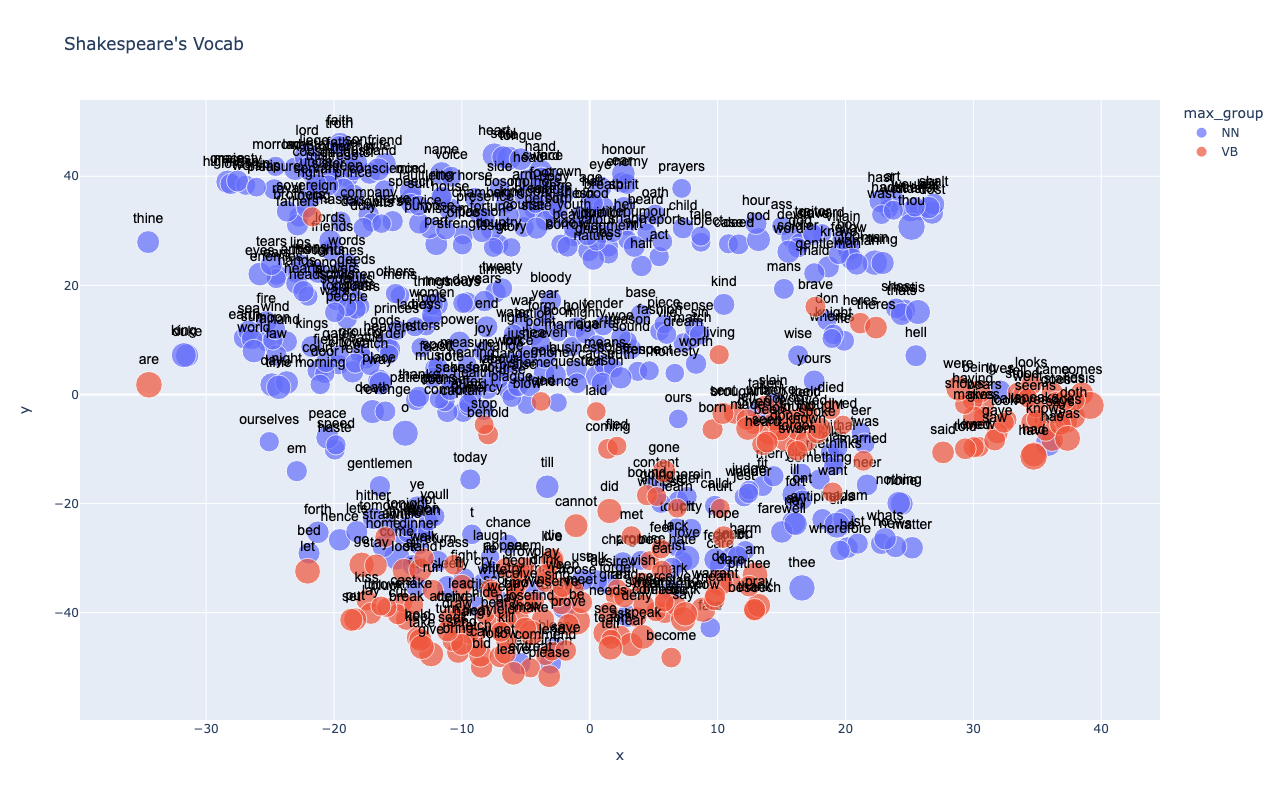

In [174]:
px.scatter(TSNE.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_group', 
           hover_name='term_str',          
           size='log_n',
           title="Shakespeare's Vocab",
           height=800).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')